In [188]:
#Problems that occured
#1- https://stackoverflow.com/questions/61102281/dataframe-object-has-no-attribute-as-matrix
#2- https://stackoverflow.com/questions/63364588/unboundlocalerror-local-variable-batch-outputs-referenced-before-assignment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
from pandas import read_csv

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [2]:
# Importing Training Set
dataset_train = pd.read_csv('Air_Land_Train_Sea.csv')

# Select features (columns) to be involved intro training and predictions
cols = list(dataset_train)[1:6]


# Extract dates (will be used in visualization)
datelist_train = list(dataset_train['Date'])
datelist_train = [dt.datetime.strptime(date, '%Y-%m').date() for date in datelist_train]

print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))

Training set shape == (252, 6)
All timestamps == 252
Featured selected: ['Air', 'Land', 'Train', 'Sea', 'Total']


In [3]:
dataset_train = dataset_train[cols].astype(str)
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# Using multiple features (predictors)
training_set = dataset_train.values

print('Shape of training set == {}.'.format(training_set.shape))
training_set

Shape of training set == (252, 5).


array([[1.695770e+05, 1.462320e+05, 2.171000e+03, 1.593500e+04,
        3.339150e+05],
       [1.951600e+05, 1.376590e+05, 2.302000e+03, 1.936600e+04,
        3.544870e+05],
       [2.616990e+05, 1.458300e+05, 2.795000e+03, 2.483400e+04,
        4.351580e+05],
       ...,
       [1.339727e+06, 3.889340e+05, 4.000000e+00, 1.363800e+04,
        1.742303e+06],
       [5.623560e+05, 2.596340e+05, 4.000000e+00, 1.199700e+04,
        8.339910e+05],
       [4.936320e+05, 1.943150e+05, 8.000000e+00, 1.137500e+04,
        6.993300e+05]])

In [4]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-1.27302228],
       [-1.24933259],
       [-1.18771791],
       [-0.95949386],
       [-0.79058432],
       [-0.6899418 ],
       [-1.32367412],
       [-0.49158382],
       [-0.50011685],
       [-0.66129897],
       [-1.08174351],
       [-1.1737317 ],
       [-1.21164836],
       [-1.16997495],
       [-1.06190873],
       [-0.79279374],
       [-0.55657096],
       [-0.45605993],
       [-0.21684342],
       [-0.36076502],
       [-0.43316567],
       [-0.74055475],
       [-1.12409105],
       [-1.2026903 ],
       [-1.24223485],
       [-1.17272237],
       [-0.99287037],
       [-0.8427335 ],
       [-0.47254539],
       [-0.36633857],
       [-0.08847665],
       [-0.07669709],
       [-0.13092511],
       [-0.4237298 ],
       [-1.0083039 ],
       [-1.09192111],
       [-1.23092013],
       [-1.1216029 ],
       [-1.13341395],
       [-1.00705288],
       [-0.64304208],
       [-0.37436601],
       [ 0.03178212],
       [ 0.12768263],
       [-0.14149996],
       [-0

In [187]:
X_train = []
y_train = []

n_future =24    #3 years   # Number of days we want to predict into the future
n_past =24      #5 years  # Number of past days we want to use to predict the future

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (205, 24, 4).
y_train shape == (205, 1).


In [188]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam


In [277]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=256, return_sequences=True, input_shape=(n_past, dataset_train.shape[1]-1)))

# Adding 2nd LSTM layer
model.add(LSTM(units=40, return_sequences=True))

# Adding 3nd LSTM layer
model.add(LSTM(units=20, return_sequences=False))

# Adding Dropout
#model.add(Dropout(0.25))
#model.add(Dropout(0.3))
# Output layer
model.add(Dense(units=1, activation='relu'))
#model.add(Dense(units=1, activation='linear'))
# Compiling the Neural Network
model.compile(optimizer = Adam(learning_rate=0.001), loss='mean_squared_error')
#model.compile(optimizer = Adam(learning_rate=0.01), loss='mean_squared_error')
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 24, 256)           267264    
_________________________________________________________________
lstm_45 (LSTM)               (None, 24, 40)            47520     
_________________________________________________________________
lstm_46 (LSTM)               (None, 20)                4880      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 21        
Total params: 319,685
Trainable params: 319,685
Non-trainable params: 0
_________________________________________________________________


In [302]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=15, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=50, callbacks=[mcp, tb], validation_split=0.2, verbose=1, batch_size=12)
#history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=3)

Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.2674
Epoch 00001: val_loss improved from inf to 1.30553, saving model to weights.h5
14/14 [==============================] - 0s 27ms/step - loss: 0.2674 - val_loss: 1.3055
Epoch 2/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2789
Epoch 00002: val_loss improved from 1.30553 to 1.20257, saving model to weights.h5
14/14 [==============================] - 0s 23ms/step - loss: 0.2679 - val_loss: 1.2026
Epoch 3/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2638
Epoch 00003: val_loss did not improve from 1.20257
14/14 [==============================] - 0s 22ms/step - loss: 0.2695 - val_loss: 1.2943
Epoch 4/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2652
Epoch 00004: val_loss did not improve from 1.20257
14/14 [==============================] - 0s 21ms/step - loss: 0.2693 - val_loss: 1.2188
Epoch 5/50
13/14 [==========================>...] - ETA: 0s - loss: 0.2714
Epoch 000

In [303]:
#EarlyStopping - Stop training when a monitored metric has stopped improving.
#monitor - quantity to be monitored.
#min_delta - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
#patience - number of epochs with no improvement after which training will be stopped.
#ReduceLROnPlateau - Reduce learning rate when a metric has stopped improving.
#factor - factor by which the learning rate will be reduced. new_lr = lr * factor.

In [304]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
#datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1d').tolist()
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_future:
    datelist_future_.append(this_timestamp.date())

In [305]:
predictions_future = model.predict(X_train[-n_future:])

In [306]:
predictions_train = model.predict(X_train[n_past:])

In [307]:
# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m'), '%Y%m')
  # return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Total']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['Total']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTION_TRAIN.head(3)

,Total
2005-12-01,1544340.875
2006-01-01,1544340.875
2006-02-01,1544340.875


In [308]:
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5


(array([18262., 18383., 18506., 18628., 18748., 18871., 18993., 19113.,
        19236., 19358.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

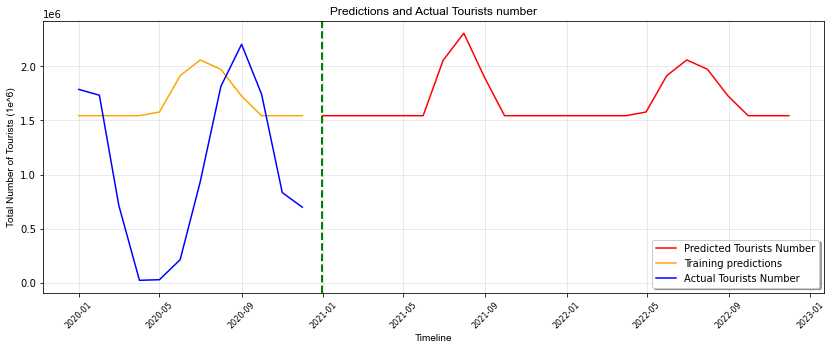

In [309]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)



# Plot parameters
START_DATE_FOR_PLOTTING = '2020-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Total'], color='r', label='Predicted Tourists Number')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Total'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Total'], color='b', label='Actual Tourists Number')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Tourists number', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Total Number of Tourists (1e^6)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)

(array([ 9496., 10957., 12418., 13879., 15340., 16801., 18262., 19723.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

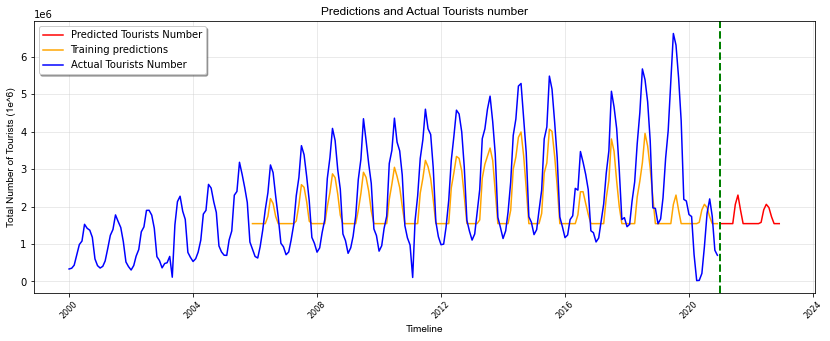

In [310]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)



# Plot parameters
START_DATE_FOR_PLOTTING = '2000-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['Total'], color='r', label='Predicted Tourists Number')
plt.plot(PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:].index, PREDICTION_TRAIN.loc[START_DATE_FOR_PLOTTING:]['Total'], color='orange', label='Training predictions')
plt.plot(dataset_train.loc[START_DATE_FOR_PLOTTING:].index, dataset_train.loc[START_DATE_FOR_PLOTTING:]['Total'], color='b', label='Actual Tourists Number')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predictions and Actual Tourists number', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Total Number of Tourists (1e^6)', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)

In [311]:
PREDICTION_TRAIN

,Total
2005-12-01,1544340.875
2006-01-01,1544340.875
2006-02-01,1544340.875
2006-03-01,1544340.875
2006-04-01,1544340.875
...,...
2020-08-01,1972764.375
2020-09-01,1725351.500
2020-10-01,1544340.875
2020-11-01,1544340.875


In [312]:
PREDICTIONS_FUTURE

,Total
2020-12-31,1544340.875
2021-01-31,1544340.875
2021-02-28,1544340.875
2021-03-31,1544340.875
2021-04-30,1544340.875
2021-05-31,1544340.875
2021-06-30,2055883.250
2021-07-31,2305962.000
2021-08-31,1898324.125
2021-09-30,1544340.875


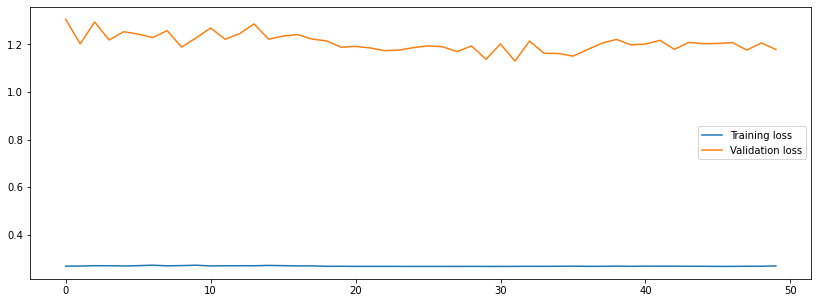

In [313]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()